# Supervised learning - Classification
Goal of the excercise is to learn how to use Scikit-learn library for a classification tasks using Decision tree, SVM and NN. Moreover evaluate the performance of the proposed models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

#### Data Dictionary

|Variable|Definition|Key|
|:-------|:-------|:--------|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

- Decision tree https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- Train test split https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- Accuracy https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
- Metrics https://scikit-learn.org/stable/modules/model_evaluation.html
- K-Fold CV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
- SVM https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

## Load the titanic.csv dataset
- We want to create a model that predicts if a certain passanger survives or not, thus **survival** is the class label in this case

In [2]:
df = pd.read_csv('datasets/ml_06/titanic.csv', index_col=0)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


## How many passangers survived?

In [3]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

## We need to pre-process the data first
- We want to use only numerical attributes as a model features
- Certain attributes need to be dropped and some of them can be encoded

### Which features would you drop and why?
### Which features could be encoded and which methods would you use?

In [5]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [6]:
df.describe(exclude=np.number)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,G6,S
freq,1,577,7,4,644


In [7]:
df.describe(include=np.number)

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## How many values are missing in the individual attributes?

In [8]:
df.isna().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Name          0
Pclass        0
Survived      0
Sex           0
Parch         0
SibSp         0
Fare          0
Ticket        0
dtype: int64

## Let's drop Name and Ticket features - these have no use for us now

In [9]:
df = df.drop(['Name', 'Ticket'], axis=1)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S
2,1,1,female,38.0,1,0,71.2833,C85,C
3,1,3,female,26.0,0,0,7.9250,NaN,S
4,1,1,female,35.0,1,0,53.1000,C123,S
5,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,NaN,S
888,1,1,female,19.0,0,0,30.0000,B42,S
889,0,3,female,NaN,1,2,23.4500,NaN,S


## Extract the deck identifier from the Cabin feature
- Note: A = top deck, G = lowest deck
- Change type to string
- Filter the first letter using *apply* function
- If the value is *nan* use *U* value as an replacement - this will mark the passangers with missing Cabin value
- Replace the T value with A

In [10]:
df.Cabin = df.Cabin.astype(str).apply(lambda x: x[0] if x != 'nan' else 'U').replace({'T': 'A'})

In [11]:
df.Cabin.value_counts()

Cabin
U    687
C     59
B     47
D     33
E     32
A     16
F     13
G      4
Name: count, dtype: int64

## The Age feature is tricky, we have multiple solutions for this, e.g.:
- Drop the feature
- Take the mean/median value to replace the missing value
- Take a random list of ages that maintains the original statistical summary values.
- Use a model to predict values based on the existing values.

### We will use the second option

<Axes: ylabel='Age'>

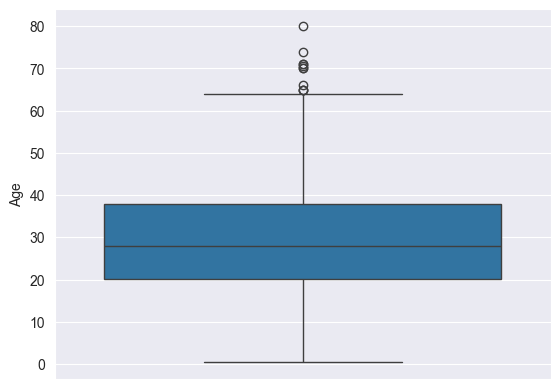

In [12]:
sns.boxplot(y=df.Age)

In [13]:
df.Age = df.Age.fillna(df.Age.mean())

<Axes: ylabel='Age'>

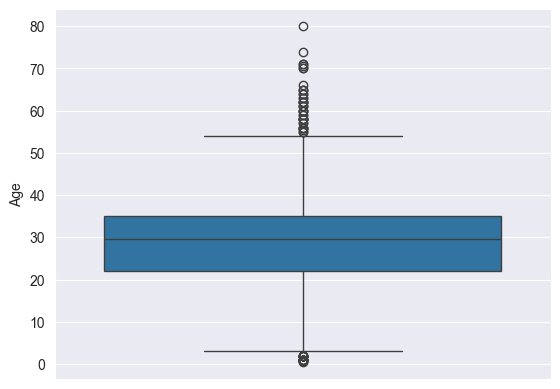

In [14]:
sns.boxplot(y=df.Age)

## Two passangers don't have the Embarked filled - we can drop these two rows

In [15]:
df = df.dropna().copy()

In [16]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.000000,1,0,7.2500,U,S
2,1,1,female,38.000000,1,0,71.2833,C,C
3,1,3,female,26.000000,0,0,7.9250,U,S
4,1,1,female,35.000000,1,0,53.1000,C,S
5,0,3,male,35.000000,0,0,8.0500,U,S
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.000000,0,0,13.0000,U,S
888,1,1,female,19.000000,0,0,30.0000,B,S
889,0,3,female,29.699118,1,2,23.4500,U,S


## The last step of the pre-processing pipeline is to encode Sex, Cabin and Embarked features
- We will use one-hot encoding for Sex and Embarked and Ordinal encoding for Cabin
- Specify the encoding scheme for the ordinal encoding using an array in a form ['first', 'second', 'third', ...]

In [17]:
cabin_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U']
enc_cabin = OrdinalEncoder(categories=[cabin_categories])
enc_cabin.fit_transform(df[['Cabin']])[:, 0]

array([7., 2., 7., 2., 7., 7., 4., 7., 7., 7., 6., 2., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 3., 7., 0., 7., 7., 7., 2., 7., 7., 7., 1., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 3., 7., 1., 2., 7., 7., 7., 7., 7., 2., 7., 7., 7., 5., 7., 7.,
       7., 7., 7., 7., 7., 7., 5., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 2., 7., 7., 7., 4., 7., 7., 7., 0., 3., 7., 7., 7., 7., 3.,
       7., 7., 7., 7., 7., 7., 7., 2., 7., 7., 7., 7., 7., 7., 7., 1., 7.,
       7., 7., 7., 4., 3., 7., 7., 7., 5., 7., 7., 7., 7., 7., 7., 7., 3.,
       2., 7., 1., 7., 7., 7., 7., 7., 7., 7., 7., 5., 7., 7., 2., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 4., 7., 7., 7., 1.,
       7., 7., 7., 0., 7., 7., 2., 7., 7., 7., 7., 7., 5., 7., 0., 7., 7.,
       7., 7., 7., 7., 7., 5., 1., 1., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       6., 7., 7., 7., 0., 7., 7., 7., 7., 7., 3., 7., 7., 3., 7., 7., 7.,
       7., 7., 2., 7., 7.

In [18]:
df['Cabin'] = enc_cabin.fit_transform(df[['Cabin']])[:, 0]

In [19]:
sex_categories = ['male', 'female']
enc_sex = OrdinalEncoder(categories=[sex_categories])
df['Sex'] = enc_sex.fit_transform(df[['Sex']])[:, 0]

In [20]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,0.0,22.0,1,0,7.2500,7.0,S
2,1,1,1.0,38.0,1,0,71.2833,2.0,C
3,1,3,1.0,26.0,0,0,7.9250,7.0,S
4,1,1,1.0,35.0,1,0,53.1000,2.0,S
5,0,3,0.0,35.0,0,0,8.0500,7.0,S


In [21]:
pd.get_dummies(df['Embarked'], prefix='Embarked')

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,False,False,True
2,True,False,False
3,False,False,True
4,False,False,True
5,False,False,True
...,...,...,...
887,False,False,True
888,False,False,True
889,False,False,True


In [22]:
df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1).drop('Embarked', axis=1)

## Now we have the data ready

In [23]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,0.0,22.000000,1,0,7.2500,7.0,False,False,True
2,1,1,1.0,38.000000,1,0,71.2833,2.0,True,False,False
3,1,3,1.0,26.000000,0,0,7.9250,7.0,False,False,True
4,1,1,1.0,35.000000,1,0,53.1000,2.0,False,False,True
5,0,3,0.0,35.000000,0,0,8.0500,7.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0.0,27.000000,0,0,13.0000,7.0,False,False,True
888,1,1,1.0,19.000000,0,0,30.0000,1.0,False,False,True
889,0,3,1.0,29.699118,1,2,23.4500,7.0,False,False,True


## Let's start with splitting the data into the input and output part
- Usually named as a *X* and *y* variables

In [24]:
X, y = df.loc[:, df.columns != 'Survived'], df.loc[:, 'Survived']

In [25]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3,0.0,22.0,1,0,7.2500,7.0,False,False,True
2,1,1.0,38.0,1,0,71.2833,2.0,True,False,False
3,3,1.0,26.0,0,0,7.9250,7.0,False,False,True
4,1,1.0,35.0,1,0,53.1000,2.0,False,False,True
5,3,0.0,35.0,0,0,8.0500,7.0,False,False,True


In [26]:
y.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

## Lets continue with train test split process.
- Note that number of rows in the *X* and *y* in the Train/Test part of the data has to be equal

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((711, 10), (178, 10), (711,), (178,))

## Create the Decision tree classifier instance

In [28]:
clf = DecisionTreeClassifier()

### Use *fit()* method for training of classifier

In [29]:
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Lets use trained model for the prediction part
- Get predictions via the method *predict()*

In [30]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0])

### Can we evaluate our model?
- There are multiple metrics used: Accuracy, Recall, Precision, F1-Score, etc.
- Very useful is also creating a confusion matrix

### Take a look at this [article](https://builtin.com/data-science/precision-and-recall) and [wiki](https://en.wikipedia.org/wiki/Precision_and_recall) about precision and recall
- Beware the fact that as we increase precision, we decrease recall and vice-versa.

- **Precision** is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate.

- **Recall** is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label?

- **F1 Score** is the harmonic mean of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall.

$ConfMatrix = \begin{bmatrix}
TP & FN\\
FP & TN
\end{bmatrix}$

In [31]:
accuracy_score(y_test, y_pred)

0.8089887640449438

## What does the confusion matrix tell us?
- Where do we find true positives, false positives etc?

<Axes: >

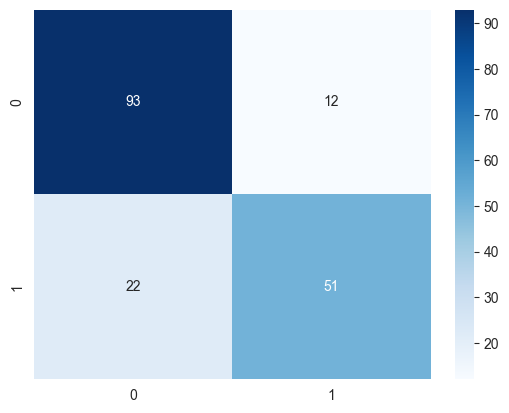

In [32]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")

In [33]:
confusion_matrix(y_test, y_pred)

array([[93, 12],
       [22, 51]])

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(np.int64(93), np.int64(12), np.int64(22), np.int64(51))

In [35]:
accuracy_score(y_test, y_pred)

0.8089887640449438

In [36]:
precision_score(y_test, y_pred)

0.8095238095238095

In [37]:
recall_score(y_test, y_pred)

0.6986301369863014

In [38]:
f1_score(y_test, y_pred)

0.75

## Can we improve our evaluation process?
- Lets try crossvalidation process for decision tree model
- https://scikit-learn.org/stable/modules/cross_validation.html
- **What is the difference between Pure and Stratified K-Fold?**

In [39]:
skf = KFold(n_splits=5)
scores = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    print(f'Survival ratio in train set: {y_train.value_counts(normalize=True)[1]:.2}; Survival ratio in test set: {y_test.value_counts(normalize=True)[1]:.2}')
scores

Survival ratio in train set: 0.4; Survival ratio in test set: 0.33
Survival ratio in train set: 0.37; Survival ratio in test set: 0.44
Survival ratio in train set: 0.38; Survival ratio in test set: 0.39
Survival ratio in train set: 0.38; Survival ratio in test set: 0.4
Survival ratio in train set: 0.39; Survival ratio in test set: 0.35


[0.6356589147286822,
 0.7417218543046358,
 0.75,
 0.6466165413533834,
 0.7559055118110236]

In [40]:
skf = StratifiedKFold(n_splits=5)
scores = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    print(f'Survival ratio in train set: {y_train.value_counts(normalize=True)[1]:.2}; Survival ratio in test set: {y_test.value_counts(normalize=True)[1]:.2}')
    
scores

Survival ratio in train set: 0.38; Survival ratio in test set: 0.38
Survival ratio in train set: 0.38; Survival ratio in test set: 0.38
Survival ratio in train set: 0.38; Survival ratio in test set: 0.38
Survival ratio in train set: 0.38; Survival ratio in test set: 0.38
Survival ratio in train set: 0.38; Survival ratio in test set: 0.38


[0.7092198581560284, 0.7246376811594203, 0.7591240875912408, 0.703125, 0.8]

In [41]:
np.mean(scores), np.min(scores), np.max(scores)

(np.float64(0.7392213253813379), np.float64(0.703125), np.float64(0.8))

In [42]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
scores = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    
scores

[0.7034482758620689,
 0.6666666666666666,
 0.7286821705426356,
 0.7428571428571429,
 0.6666666666666666]

In [43]:
np.mean(scores), np.min(scores), np.max(scores)

(np.float64(0.7016641845190361),
 np.float64(0.6666666666666666),
 np.float64(0.7428571428571429))

## Other way to use crossvalidation in Sklearn

In [44]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
scores

array([0.68571429, 0.71942446, 0.75      , 0.70676692, 0.78873239])

In [45]:
np.mean(scores), np.min(scores), np.max(scores)

(np.float64(0.7301276115610741),
 np.float64(0.6857142857142857),
 np.float64(0.7887323943661971))

## Scale our data

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

In [47]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_scaled, y, cv=5, scoring='f1')
scores

array([0.69503546, 0.71428571, 0.7480916 , 0.67692308, 0.7826087 ])

In [48]:
np.mean(scores), np.min(scores), np.max(scores)

(np.float64(0.7233889101814617),
 np.float64(0.676923076923077),
 np.float64(0.782608695652174))

# Let's try other algorithms - SVM and ANN
- SVM - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- SVM demo 1 - https://www.csie.ntu.edu.tw/~cjlin/libsvm/
- SVM demo 2 - https://cs.stanford.edu/~karpathy/svmjs/demo/
- SVM kernel trick https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-iii-5dff33fa015d
- ANN - https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
- ANN demo - https://playground.tensorflow.org/

### Task 1: SVM (1b)
- Take a look at the parameters of the SVM, e.g. C, kernel, gamma (in case of RBF)
- **Try at least 5 different parameter's configurations**, use both linear and RBF kernel, you can also experiment with other
- **Does the preprocesing help with classifier perfromance?** Use both **X** and **X_scaled** for training and evaluating
- Tune the hyper-parameters and compare classification results after crossvalidation validation step
    - When using RBF kernel show a relation between parameters C and gamma. You can create table or heatmap similar to the one in the lecture.
    - **Write down to markdown cell which is better and why!**
- *Implementation note in Sklearn: SVC(kernel='linear') might be slow, u can use LinearSVC instead.*

In [49]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
configs =[
    {'kernel': 'linear', 'C': 1},
    {'kernel': 'linear', 'C': 10},
    {'kernel': 'rbf', 'C': 1, 'gamma': 0.1},
    {'kernel': 'rbf', 'C': 10, 'gamma': 0.01},
    {'kernel': 'rbf', 'C': 100, 'gamma': 0.001},
]

In [51]:
results = []
for config in configs:
    clf = SVC(**config)
    
    accuracy_raw = cross_val_score(clf, X, y, cv=5, scoring='f1')
    accuracy_scaled = cross_val_score(clf, X_scaled, y, cv=5, scoring='f1')
    
    results.append({
        'kernel': config['kernel'],
        'C': config['C'],
        'gamma': config.get('gamma', 'N/A'),
        'raw': accuracy_raw,
        'scaled': accuracy_scaled,
    })
    
pd.DataFrame(results)

,kernel,C,gamma,raw,scaled
0,linear,1,N/A,"[0.7407407407407407, 0.7424242424242424, 0.712...","[0.7407407407407407, 0.7424242424242424, 0.712..."
1,linear,10,N/A,"[0.7407407407407407, 0.7424242424242424, 0.712...","[0.7407407407407407, 0.7424242424242424, 0.712..."
2,rbf,1,0.1,"[0.4032258064516129, 0.6060606060606061, 0.564...","[0.75, 0.7424242424242424, 0.7424242424242424,..."
3,rbf,10,0.01,"[0.656934306569343, 0.6713286713286714, 0.6865...","[0.7424242424242424, 0.7480916030534351, 0.732..."
4,rbf,100,0.001,"[0.7074829931972789, 0.7310344827586207, 0.714...","[0.7368421052631579, 0.7424242424242424, 0.712..."


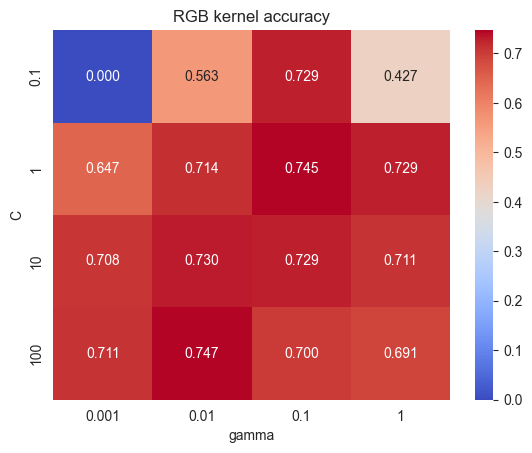

In [52]:
C_range = [0.1, 1, 10, 100]
gamma_range = [0.001, 0.01, 0.1, 1]

scores = []
for C in C_range:
    row = []
    for gamma in gamma_range:
        svc = SVC(kernel='rbf', C=C, gamma=gamma)
        score = cross_val_score(svc, X_scaled, y, cv=5, scoring='f1').mean()
        row.append(score)
    scores.append(row)
    
scores = np.array(scores)

sns.heatmap(scores, annot = True, fmt=".3f", xticklabels=gamma_range, yticklabels=C_range, cmap = "coolwarm")
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('RGB kernel accuracy')
plt.show()

### Výsledky SVM

- Škálovanie dát výrazne pomohlo pri RBF kerneli, pretože tento kernel je citlivý na rozsah vstupných premenných.
- Lineárny kernel mal podobný výkon s aj bez škálovania.
- Najlepšie výsledky dosiahol RBF kernel s C=10 a γ=0.1.
- Pre malé C bol model podfitovaný, pre veľké C prefitovaný.
- Najlepší kompromis medzi generalizáciou a presnosťou bol pri stredných hodnotách parametrov.
m
- Preto je **RBF kernel so škálovanými dátami lepší**, pretože dokáže modelovať nelineárne hranice a je citlivý na mierku atribútov.


### Task 2: NN (1b)
- Take a look at the parameters of the MLPClassifier, e.g. hidden_layer_sizes, activation, solver, max_iter
- Tune the hyper-parameters and compare the ANN model proposed during the lecture
    - Choose the ideal form of presentation for hyperparameter tuning results (e.g. table with scores, plot showing the score relation to some parameter, etc.)
    - **Write down to markdown cell which is better and why!**

In [53]:
X, y
X_scaled

array([[ 0.82520863, -0.73534203, -0.59049493, ..., -0.48271079,
        -0.30794088,  0.61679395],
       [-1.57221121,  1.35991138,  0.64397101, ...,  2.07163382,
        -0.30794088, -1.62128697],
       [ 0.82520863,  1.35991138, -0.28187844, ..., -0.48271079,
        -0.30794088,  0.61679395],
       ...,
       [ 0.82520863,  1.35991138,  0.00352373, ..., -0.48271079,
        -0.30794088,  0.61679395],
       [-1.57221121, -0.73534203, -0.28187844, ...,  2.07163382,
        -0.30794088, -1.62128697],
       [ 0.82520863, -0.73534203,  0.18104628, ..., -0.48271079,
         3.24737656, -1.62128697]], shape=(889, 10))

In [54]:
configs = [
    {'hidden_layer_sizes': (10,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 5000},
    {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'max_iter': 5000},
    {'hidden_layer_sizes': (30,10), 'activation': 'tanh', 'solver': 'adam', 'max_iter': 5000},
    {'hidden_layer_sizes': (30,10), 'activation': 'relu', 'solver': 'lbfgs', 'max_iter': 5000},
    {'hidden_layer_sizes': (100,50,25), 'activation': 'relu', 'solver': 'adam', 'max_iter': 8000},
]

results = []
for config in configs:
    clf = MLPClassifier(**config)
    
    score = cross_val_score(clf, X_scaled, y, cv=5, scoring='f1')
    
    results.append({
        'hidden_layers': config['hidden_layer_sizes'],
        'activation': config['activation'],
        'solver': config['solver'],
        'max_iter': config['max_iter'],
        'accuracy': score,
    })

df_results = pd.DataFrame(results)
print(df_results)



   hidden_layers activation solver  max_iter  \
0          (10,)       relu   adam      5000   
1          (50,)       relu   adam      5000   
2       (30, 10)       tanh   adam      5000   
3       (30, 10)       relu  lbfgs      5000   
4  (100, 50, 25)       relu   adam      8000   

                                            accuracy  
0  [0.7479674796747967, 0.734375, 0.78125, 0.6837...  
1  [0.7401574803149606, 0.7175572519083969, 0.806...  
2  [0.6923076923076923, 0.6515151515151515, 0.803...  
3  [0.6811594202898551, 0.6666666666666666, 0.698...  
4  [0.671875, 0.6911764705882353, 0.7716535433070...  


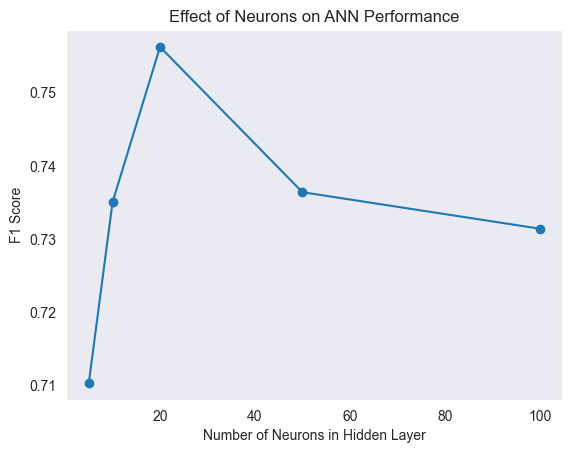

In [55]:
neurons = [5,10,20,50,100]
scores = []
for n in neurons:
    clf = MLPClassifier(hidden_layer_sizes=(n,), activation='relu', solver='adam', max_iter=5000)
    score = cross_val_score(clf, X_scaled, y, cv=5, scoring='f1').mean()
    scores.append(score)
    
plt.plot(neurons, scores, marker='o')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('F1 Score')
plt.title('Effect of Neurons on ANN Performance')
plt.grid()
plt.show()


### Výsledky ANN (MLPClassifier)

- Najlepší výkon dosiahla konfigurácia `hidden_layer_sizes=(50,)` s aktivačnou funkciou **ReLU** a solverom **Adam**.
- Pri menších sieťach (napr. (10,)) bol model podfitovaný – nižšie skóre.
- Pri väčších sieťach (napr. (100,50,25)) sa výkon mierne znížil, pravdepodobne kvôli pretrénovaniu.
- Solver **Adam** poskytol stabilné a rýchle konvergovanie.
- Solver **LBFGS** mal o niečo slabšie výsledky na tomto datasete.
- Trend v grafe ukazuje, že optimálny počet neurónov v skrytej vrstve sa pohybuje okolo **30–50**.

➡ **Záver:**  
Škálované dáta + solver `adam` + ReLU aktivácia a stredne veľká sieť poskytli najlepšie výsledky.  
Zvyšovanie počtu neurónov nad 50 už neprinieslo zlepšenie, pretože model začal pretrénovávať.


### Bonus task: OPTUNA (1b)
Use **Optuna** library for hyperparameter tuning process for one of previous classification methods (SVM, ANN).

A short list with some materials for this task:
- Hyperparameter tuning blog 1 https://medium.com/@iqra.bismi/hyper-parameter-tuning-of-machine-learning-models-using-optuna-f1905547937f
- Hyperparameter tuning blog 2 https://medium.com/@abdalrahman_shahrour/optuna-vs-gridsearch-57227556c450
- https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html
- https://github.com/optuna/optuna
- https://github.com/optuna/optuna-dashboard and https://optuna.github.io/optuna-dashboard/

**What is the difference in using the Optuna instead of grid search?**

In [56]:
X_data = X_scaled
y_data = y

In [60]:
import optuna

def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    gamma = trial.suggest_float('gamma', 1e-4, 1e1, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    
    clf = SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)
    
    score = cross_val_score(clf, X_scaled, y, cv=5).mean()
    return score


In [ ]:

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

[I 2025-11-04 20:09:01,026] A new study created in memory with name: no-name-13c65f6b-5384-4e2b-9012-3ae695a8e012
[I 2025-11-04 20:09:01,987] Trial 0 finished with value: 0.8077064686091537 and parameters: {'C': 0.06739204479896528, 'gamma': 1.0238416368869279, 'kernel': 'poly'}. Best is trial 0 with value: 0.8077064686091537.
[I 2025-11-04 20:09:02,178] Trial 1 finished with value: 0.6175458642798197 and parameters: {'C': 0.021902954971003693, 'gamma': 0.00021577860548172435, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8077064686091537.
[I 2025-11-04 20:09:02,291] Trial 2 finished with value: 0.6659620389767029 and parameters: {'C': 0.9935439350259444, 'gamma': 0.2689644879073471, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.8077064686091537.
[I 2025-11-04 20:09:02,462] Trial 3 finished with value: 0.7356630483082587 and parameters: {'C': 0.014109278509742851, 'gamma': 6.897291573092991, 'kernel': 'sigmoid'}. Best is trial 0 with value: 0.8077064686091537.
[I 2025-11-04 20: